## <img src="./logoUtn.jpg" align="right" width="200" /> 
#### Procesamiento Digital de Señales

# Trabajo Práctico Final
#### Sidorczuk Nicolás Andrés

***
## Filtrado de señal de ECG mediante analisis multiresolución utilizando transformada wavelet

### Introducción
Durante un Electrocardiograma (ECG) se registra la actividad eléctrica cardíaca y el mismo es utilizado para investigar  o detectar enfermedades cardiacas. Al realizarlo la señal es contaminada con ruido proveniente de diversas fuentes como la variación de la línea de base (baja frecuencia) o ruido muscular y ruido por el movimiento de electrodos (alta frecuencia).
<img src="./ecg_cardiac_cicle.jpg" align="center" width="60%" />
<center>Fig.1: Ejemplo señal ECG</center>

En este trabajo se realiza una descomposición de la señal de ECG para luego reducir la presencia de ruido utilizando la transformada wavelet. Una función de tipo "wavelet" $\psi_{s,\tau}(t)$ tiene caracter pasabanda y a la misma se le aplica una traslación y escalado en el tiempo.
$$\psi_{s,\tau}(t) = \frac{1}{\sqrt{s}}\psi \left( \frac{t-\tau}{s} \right) $$
De esta manera mediante el escalado cambiamos la respuesta frecuencial y con la traslación se retiene información temporal de la señal a analizar. A medida que se reduce el parametro de escalado $s$ la wavelet se comprime en tiempo pero su localización en frecuencia crece al igual que se ensancha su resolución frecuencial (mayor ancho de banda).

Al realizar la transformada wavelet continua con $\psi_{s,\tau}(t)$ sobre la señal de interes $x\left(t\right)$ se realiza la correlación entre las señales obteniendose un mapeo bidimensional tiempo-escala (tiempo-frecuencia).
$$ \omega\left(s,\tau\right) = \int_{-\infty}^\infty x\left(t\right) \frac{1}{\sqrt{s}}\psi \left( \frac{t-\tau}{s} \right) dt $$

### Aplicación de la transformada continua
A modo de ejemplo del uso de la transformada wavelet continua (CWT) se realizo una gráfica tiempo-frecuencia de un promedio de latidos normales.

In [1]:
# Inicialización del notebook
import pywt
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal as sig

mat_struct = sio.loadmat('./ECG_signal.mat')
qrs_det = mat_struct['qrs_detections']
ecg_one_lead = mat_struct['ecg_lead']

# La señal fue muestreada a 1KHz
fs = 1000
Ts = 1/fs

Se toman un buena cantidad de latidos normales a partir de la señal de ECG y de la información de de ubicación de los latidos. Al promediar los latidos se elimina buena parte del ruido de la señal.

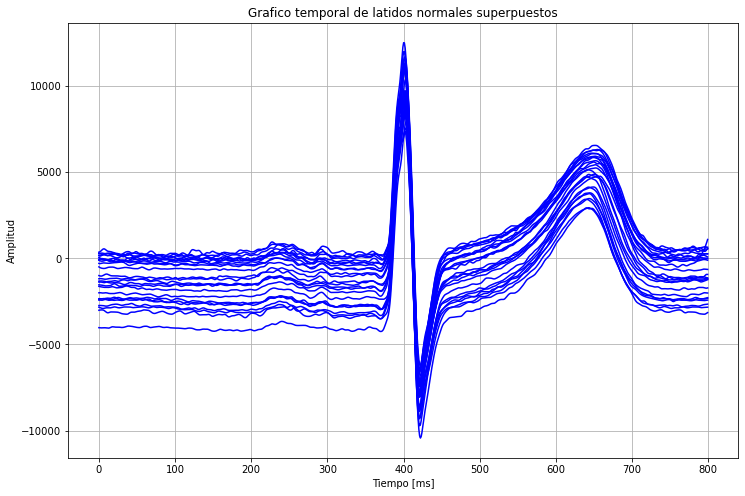

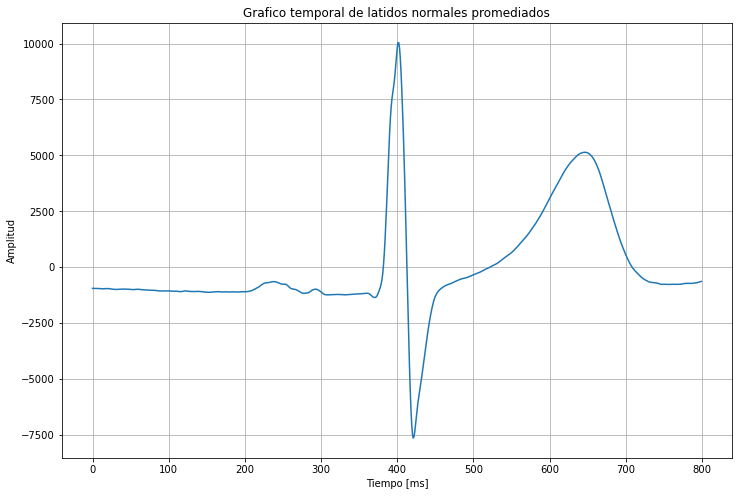

In [2]:
# Grafico Tiempo-Frecuencia de cwt de promedio de latidos
normal_hb = np.arange(0,10)
b = np.arange(14,29)
normal_hb = np.concatenate((normal_hb,b))

N = 800
N2 = int(N/2)
latidos = np.zeros([N,len(normal_hb)])
i = 0
plt.figure(figsize=(12, 8))
plt.title('Grafico temporal de latidos normales superpuestos')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [ms]')
plt.grid(True)
for pos in normal_hb:
    lat_pos = int(qrs_det[pos])
    lat = ecg_one_lead[lat_pos-N2:lat_pos+N2]
    latidos[:,i] = lat[:,0]
    i += 1
    plt.plot(lat, color="blue")
    
hb_avg = np.mean(latidos,axis=1)
hb_avg -= np.mean(hb_avg)
plt.figure(figsize=(12, 8))
plt.plot(hb_avg)
plt.title('Grafico temporal de latidos normales promediados')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [ms]')
plt.grid(True)

Tomando el latido normal promedio le aplico la CWT con un conjunto de escalas obteniendo una señal temporal por cada escala del mismo número de muestras. Por la naturaleza pasabanda de las wavelet, se logra una descomposición espectral con cada escala de la CWT del latido. Se puede asociar las escalas a valores en frecuencia y se genera una imagen tiempo-frecuencia donde se usa un rango de colores para indicar la intensidad de ese espectro frecuencial del latido en ese determinado momento

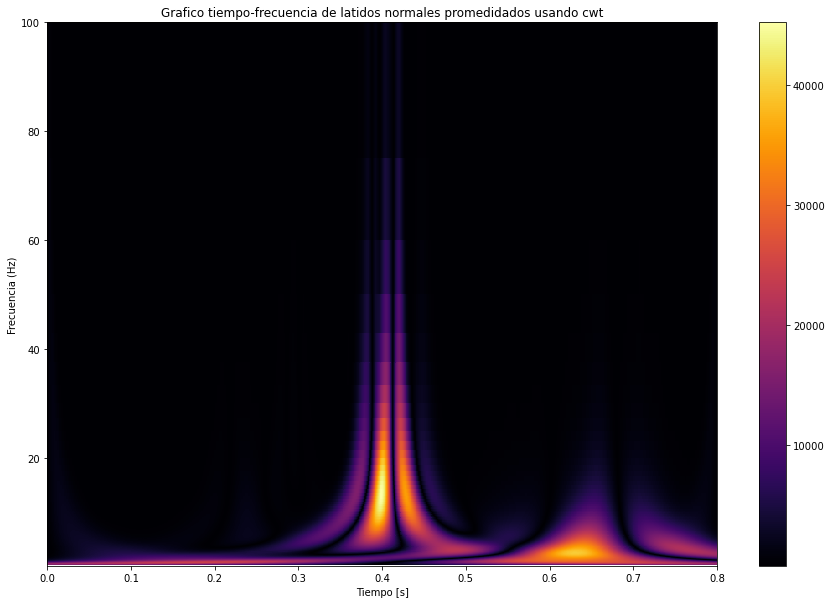

In [3]:
# Elección de escalas para usar con la CWT
widths = np.arange(3, 1000)
# 
cwtmatr, freqs = pywt.cwt(hb_avg.reshape(N),widths,'gaus2',sampling_period=Ts)
t = np.linspace(start=0, stop=N*Ts, num=N)
plt.figure(figsize=(15, 10))
plt.pcolormesh(t, freqs, abs(cwtmatr), cmap = "inferno")
plt.title('Grafico tiempo-frecuencia de latidos normales promedidados usando cwt')
plt.ylabel('Frecuencia (Hz)')
plt.xlabel('Tiempo [s]')
plt.colorbar()

Si se observa la imagen con detenimiento se puede apreciar que se compone de segmentos de colores. Esto se explica recordando que el escalado genera un desplazamiento de la respuesta frecuencial de la wavelet asi como su resolución espectral y en la práctica se usa un número finito de escalas. A medida que aumenta la frecuencia 
Si se compara con el gráfico del latido normal se ve una clara relación. Lo mas destacado es la ubicación temporal entre los picos de la cwt que se corresponden al complejo QRS cerca de $0.4ms$ y a la onda T alrededor de los $0.65ms$. Además en esos puntos se ve información de como se componen frecuencialmente dichas ondas.

### Analisis multiresolución mediante DWT
Como la transformada continua es redundante, se discretiza los parametros de escalado y traslación dando lugar a la transformada wavelet discreta (DWT). Haciendo uso de la DWT vamos a realizar un analisis multiresolución de la señal de ECG.

Al aplicar la DWT a una señal obtengo dos vectores de coeficientes, uno de aproximación y otro de detalle. Los coeficientes de aproximación representan la forma aproximada de la señal, es decir, tiene caracteristicas pasa-bajo. Mientras que los coeficientes de detalle tienen la información de las variaciones mas rápidas, es decir, tiene caracteristicas pasa-alto. De esta manera podemos ver a la DWT como el proceso de separar mediante un filtro pasa-bajo y otro pasa-alto a la señal original. Si se vuelve a apilcar a la señal de detalle la DWT, se vuelve a descomponer en una parte de baja (aproximación) y una de alta frecuencia (detalle) solo que esta vez la parte de alta frecuencia tiene caracter pasa-banda ya que viene de un filtro pasa-bajos previo mientras que la parte de baja frecuencia se vuelve cada vez mas acotada. Por lo tanto el analisis multiresolución consiste en descomponer mediante el uso de la DWT a mi señal de interes con una serie de filtros pasa-bajo y pasa-alto en una serie de coeficientes dada por el nivel de descomposición empleado.

### Filtrado
Primero descompongo la señal de ECG con 10 niveles de descomposición usando la wavelete coiflet4. Esto resulta en un vector de coeficientes de aproximacióncon la información de mas baja frecuencia y 10 vectores de detalle donde cada uno tiene una porción pasabanda de la señal original. Una vez descompuesta la señal modifico los valores de los coeficientes obtenidos. 

Para filtrar ruido de alta frecuencia determino un nivel de threshold para comparar con todos los coeficientes de detalle de todos los niveles de descomposición. Para el nivel de threshold inicialmente lo elijo a partir de una estimación del desvio estandar del ruido de la señal [1]. Para estimar el ruido calculo la mediana entre todos los coeficiente de detalle de todos los niveles. El threshold resultante no fue suficiente para lograr un filtrado apreciable de alta frecuencia, por lo tanto lo agrande 4 veces. Ademas para cada nivel de descomposición $j$ a partir del de mas alta frecuencia, agrando el threshold diviendo por $\ln \left(j+2\right)$ [2].

Los coeficientes que esten por debajo del threshold los igualo a cero. Los coeficientes por arriba del threshold van a ser modificados utilizando una expresión [2] que busca obtener una buena morfologia en la señal filtrada. Esta expresión utiliza una función exponencial con la cual los coeficientes iguales al threshold toman un valor igual a cero, pero a medida que aumentan van aumentando exponencialmente de valor de modo que para valores altos prácticmente no se modifique su valor.

Para eliminar el ruido de baja frecuencia elimino por completo la parte de mas baja frecuencia, es decir, igualo a cero todos los coeficientes del vector de aproximación.

In [4]:
def WaveletFilter(ecg,wavelet,level):
    N = len(ecg)
    
    # Descomposición del ecg en coeficientes
    coeffs = pywt.wavedec(ecg.reshape(N), wavelet, level=level)
    
    # Calculo de threshold
    desvio = 1.483 * np.median(abs(np.concatenate(coeffs[1:-1], axis=None)))
    th = desvio*np.sqrt(2*np.log(N)) * 4
    
    # Filtrado de alta frecuencia
    for j in range(1,len(coeffs)):
        threshold = th / np.log(LastLevel-j+2)
        for i in range(len(coeffs[j])):
            absWjk = abs(coeffs[j][i])
            if absWjk < threshold:
                coeffs[j][i] = 0
            else:
                coeffs[j][i] = np.sign(coeffs[j][i]) * (absWjk - threshold/np.exp((absWjk-threshold)/threshold))
                
    # Remoción de la variación de la línea de base
    coeffs[0][:] = 0
    
    return pywt.waverec(coeffs, wavelet) # Recupero señal de ecg a partir de coeficientes modificados

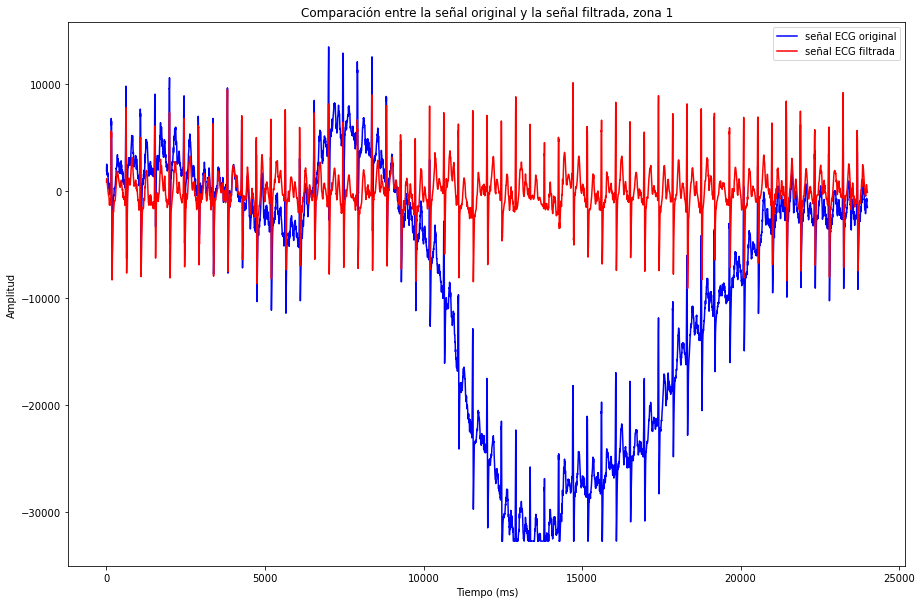

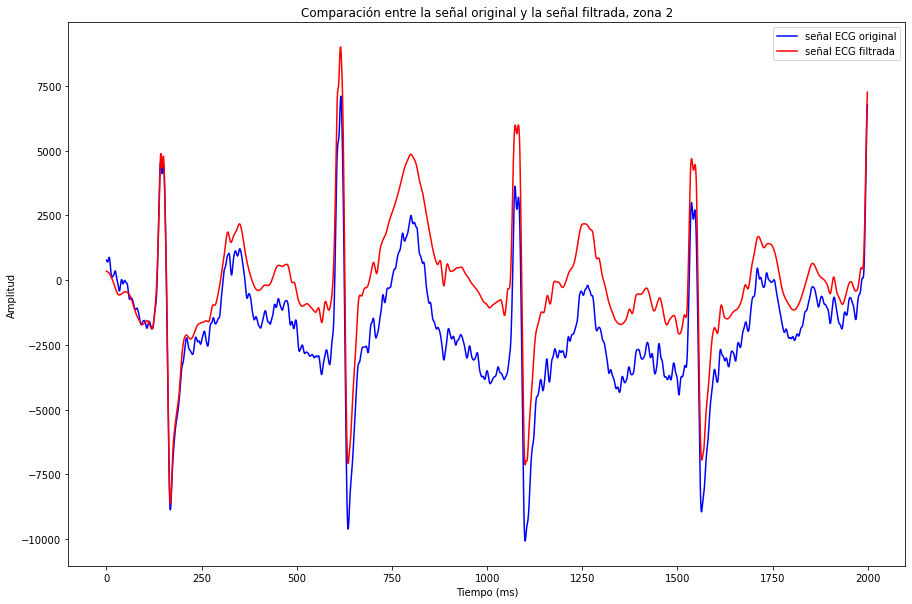

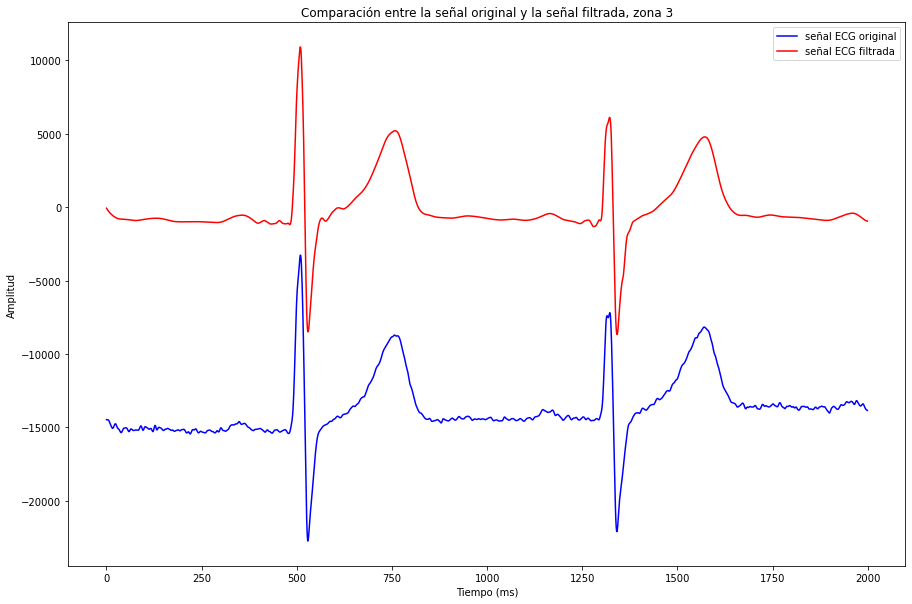

In [5]:
# Filtrado del ruido de alta frecuencia del ecg realizando una descomposicion multiresolucion con la dwt
# Usando la funcion exponencial

N = len(ecg_one_lead)
LastLevel = 10

coeffs = pywt.wavedec(ecg_one_lead.reshape(N), 'coif4', level=LastLevel)
desvio = 1.483 * np.median(abs(np.concatenate(coeffs[1:-1], axis=None)))
th = desvio*np.sqrt(2*np.log(N)) * 4
for j in range(1,len(coeffs)):
    threshold = th / np.log(LastLevel-j+2)
    for i in range(len(coeffs[j])):
        absWjk = abs(coeffs[j][i])
        if absWjk < threshold:
            coeffs[j][i] = 0
        else:
            coeffs[j][i] = np.sign(coeffs[j][i]) * (absWjk - threshold/np.exp((absWjk-threshold)/threshold))
coeffs[0][:] = 0
signal_coif4 = pywt.waverec(coeffs, 'coif4')

plt.figure(figsize=(15, 10))
plt.plot(ecg_one_lead[720000:744000],color='blue',label='señal ECG original')
plt.plot(signal_coif4[720000:744000],color='red',label='señal ECG filtrada')
plt.title('Comparación entre la señal original y la señal filtrada, zona 1')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo (ms)')
plt.legend(loc="best")

plt.figure(figsize=(15, 10))
plt.plot(ecg_one_lead[710800:712800],color='blue',label='señal ECG original')
plt.plot(signal_coif4[710800:712800],color='red',label='señal ECG filtrada')
plt.title('Comparación entre la señal original y la señal filtrada, zona 2')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo (ms)')
plt.legend(loc="best")

plt.figure(figsize=(15, 10))
plt.plot(ecg_one_lead[108000:110000],color='blue',label='señal ECG original')
plt.plot(signal_coif4[108000:110000],color='red',label='señal ECG filtrada')
plt.title('Comparación entre la señal original y la señal filtrada, zona 3')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo (ms)')
plt.legend(loc="best")

Se puede apreciar en los distinitos gráficos los resultados del filtrado. En el correspondiente a la zona 1, se aprecia una mejora notoria en la variación de lina de base (ruido de baja frecuencia) de la señal de ecg. En los graficos de la zona 2 y 3 también es marcado el cambio en la linea de base pero se aprecia mucho mejor el filtrado de alta frecuencia. Un punto importante a destacar es que la morfología general de la señal no se ve afectada. 

A modo de comparación con la transformada wavelet realizo el filtrado de baja frecuencia estimando la variación de linea de base con filtros de mediana y la sustraigo de la señal de ecg.

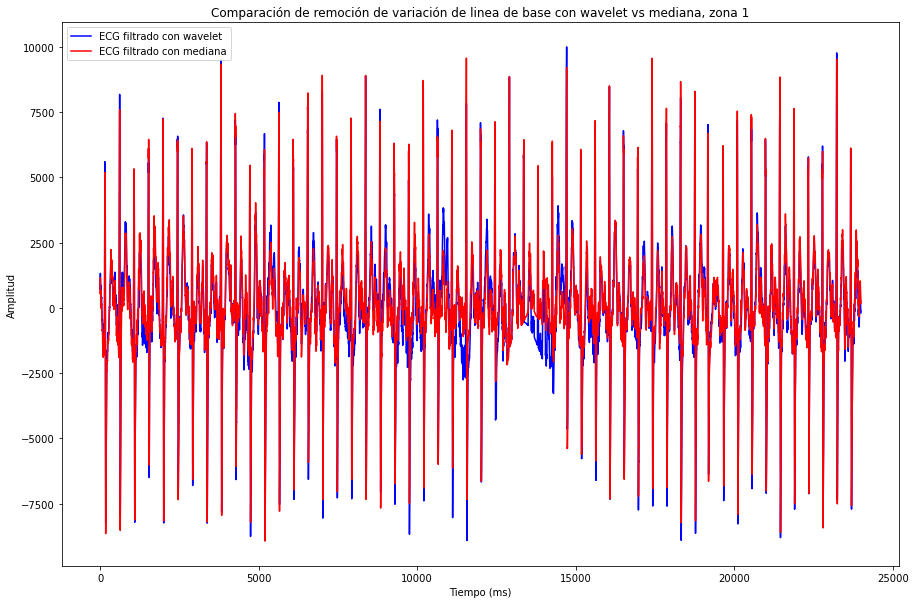

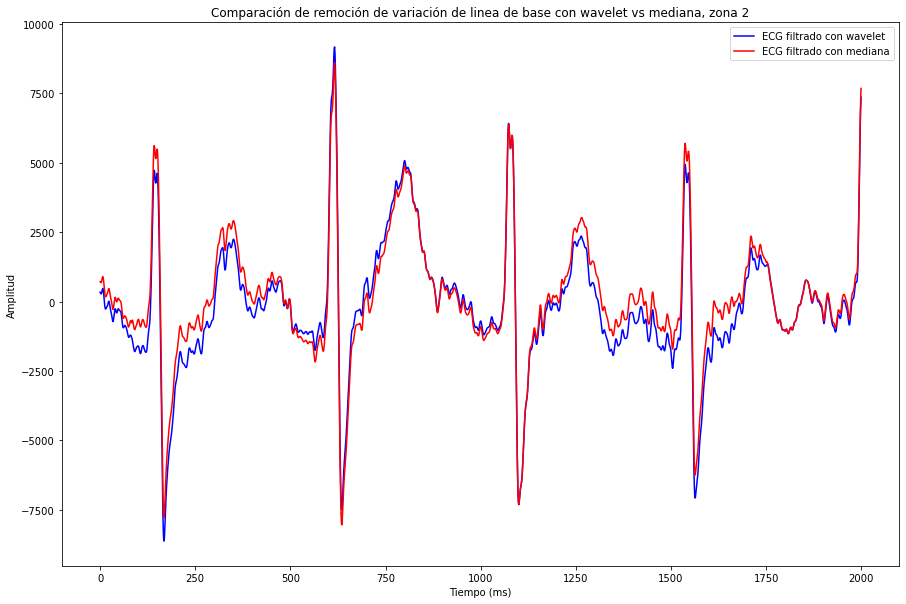

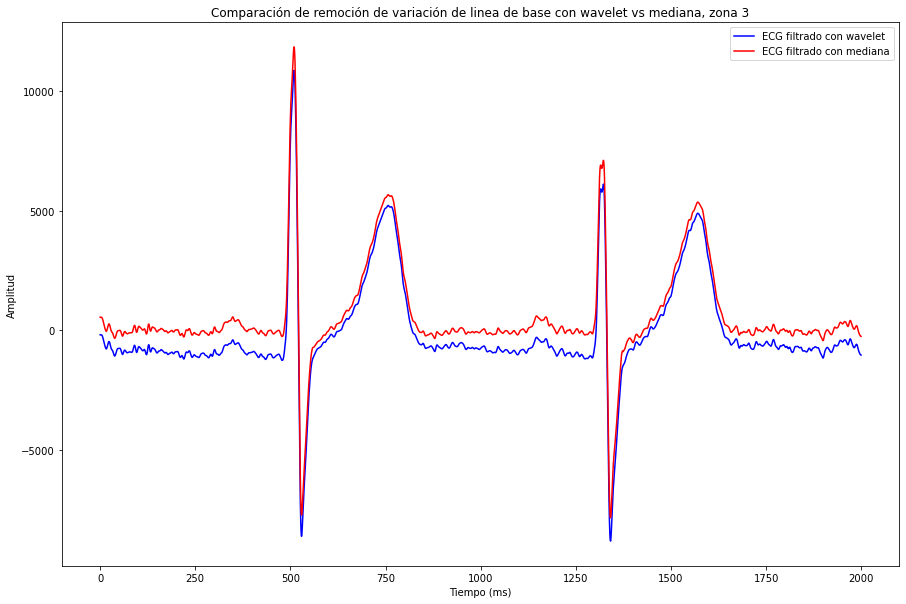

In [6]:
# Filtrado del ruido de baja frecuencia del ecg realizando una descomposicion multiresolucion con la dwt
import time

start_time = time.process_time()
N = len(ecg_one_lead)
LastLevel = 10
coeffs = pywt.wavedec(ecg_one_lead.reshape(N), 'coif4', level=LastLevel)
coeffs[0][:] = 0
ecg_sLB = pywt.waverec(coeffs, 'coif4')
stop_time = time.process_time()
tiempo_wavelet = stop_time-start_time

# Comparación con la mediana
start_time = time.process_time()
linea_base = sig.medfilt(ecg_one_lead.flatten(),201) # 201
linea_base = sig.medfilt(linea_base.flatten(),601) # 601
S_B = ecg_one_lead - linea_base.reshape(N,1)
stop_time = time.process_time()
tiempo_mediana = stop_time-start_time

plt.figure(figsize=(15, 10))
plt.plot(ecg_sLB[720000:744000],color='blue',label='ECG filtrado con wavelet')
plt.plot(S_B[720000:744000],color='red',label='ECG filtrado con mediana')
plt.title('Comparación de remoción de variación de linea de base con wavelet vs mediana, zona 1')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo (ms)')
plt.legend(loc="best")

plt.figure(figsize=(15, 10))
plt.plot(ecg_sLB[710800:712800],color='blue',label='ECG filtrado con wavelet')
plt.plot(S_B[710800:712800],color='red',label='ECG filtrado con mediana')
plt.title('Comparación de remoción de variación de linea de base con wavelet vs mediana, zona 2')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo (ms)')
plt.legend(loc="best")

plt.figure(figsize=(15, 10))
plt.plot(ecg_sLB[108000:110000],color='blue',label='ECG filtrado con wavelet')
plt.plot(S_B[108000:110000],color='red',label='ECG filtrado con mediana')
plt.title('Comparación de remoción de variación de linea de base con wavelet vs mediana, zona 3')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo (ms)')
plt.legend(loc="best")

Los resultados son similares, aunque con el filtrado de mediana la señal queda ubicada sobre el cero de amplitud. Sin embargo realizando un estimación aproxiamda del tiempo que tarda cada metodo se puede comparar y observar a continuación que el metodo de la mediana es mucho mas lento

In [7]:
print("Tiempo de filtrado con wavelet:",tiempo_wavelet)
print("Tiempo de filtrado con mediana:",tiempo_mediana)

Tiempo de filtrado con wavelet: 0.03125
Tiempo de filtrado con mediana: 50.203125


Un aspecto muy importante para el analisis con transformada wavalet es precisamente la elección de la wavelet. Para esto realizo el mismo filtrado pero cambiando la wavavelet a la daubechies2 y comparo con la coiflet4

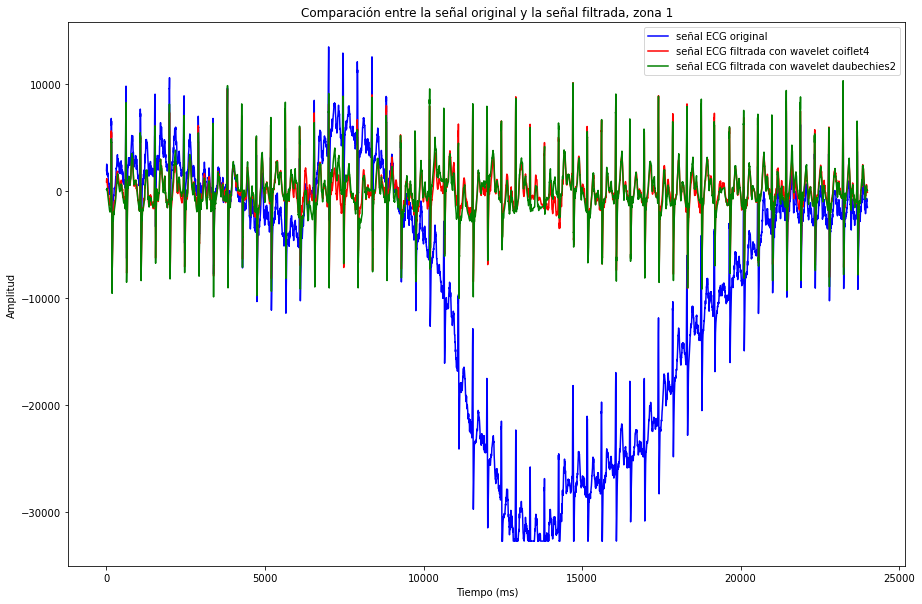

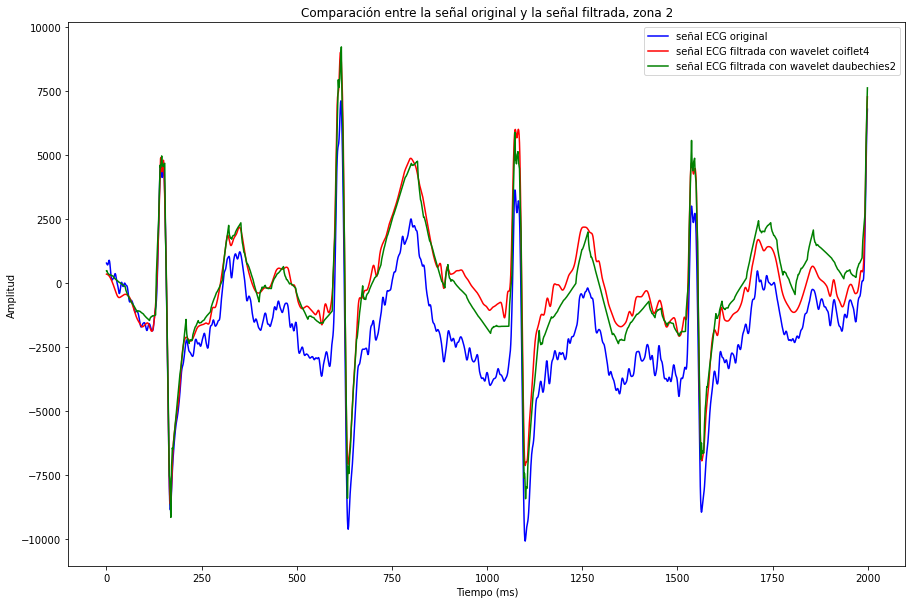

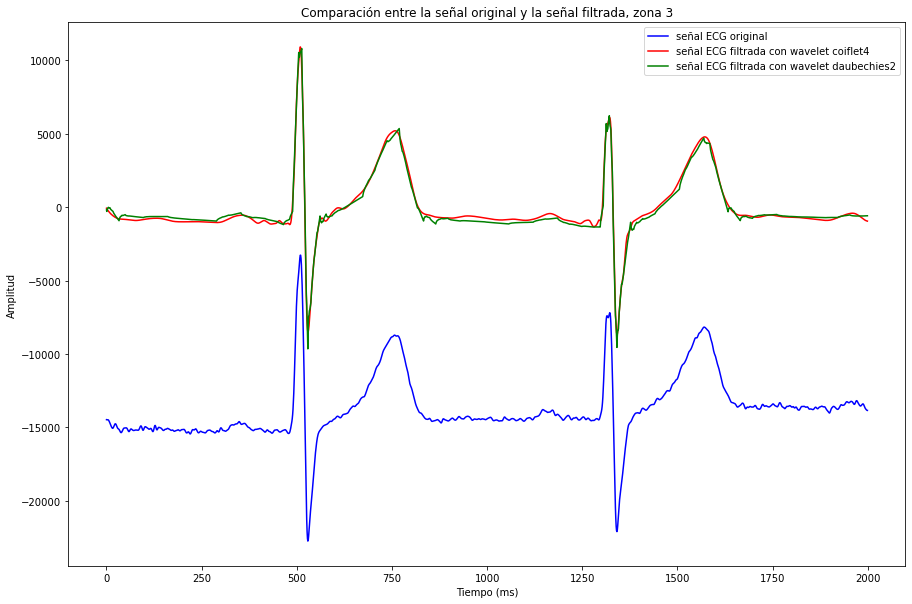

In [8]:
# Comparacion con distintas wavelets
signal_db2 = WaveletFilter(ecg=ecg_one_lead, wavelet='db2', level = 10)
plt.figure(figsize=(15, 10))
plt.plot(ecg_one_lead[720000:744000],color='blue',label='señal ECG original')
plt.plot(signal_coif4[720000:744000],color='red',label='señal ECG filtrada con wavelet coiflet4')
plt.plot(signal_db2[720000:744000],color='green',label='señal ECG filtrada con wavelet daubechies2')
plt.title('Comparación entre la señal original y la señal filtrada, zona 1')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo (ms)')
plt.legend(loc="best")

plt.figure(figsize=(15, 10))
plt.plot(ecg_one_lead[710800:712800],color='blue',label='señal ECG original')
plt.plot(signal_coif4[710800:712800],color='red',label='señal ECG filtrada con wavelet coiflet4')
plt.plot(signal_db2[710800:712800],color='green',label='señal ECG filtrada con wavelet daubechies2')
plt.title('Comparación entre la señal original y la señal filtrada, zona 2')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo (ms)')
plt.legend(loc="best")

plt.figure(figsize=(15, 10))
plt.plot(ecg_one_lead[108000:110000],color='blue',label='señal ECG original')
plt.plot(signal_coif4[108000:110000],color='red',label='señal ECG filtrada con wavelet coiflet4')
plt.plot(signal_db2[108000:110000],color='green',label='señal ECG filtrada con wavelet daubechies2')
plt.title('Comparación entre la señal original y la señal filtrada, zona 3')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo (ms)')
plt.legend(loc="best")

Con ambas wavelet se logra eliminar el ruido de baja y alta frecuencia, pero con la de coiflet la señal es mucho mas suave que con la de daubechies

### Referencias
[1] Leif Sörnmo y Pablo Laguna, "Bioelectrical signal processing in cardiac and neurological applications", Academic Press

[2] Lu Jing-yi, Lin Hong, Ye Dong, and Zhang Yan-sheng, "A New Wavelet Threshold Function and Denoising Application", Hindawi Publishing Corporation 2016